## Task 4.2: Supervised ML - Classification

**Author**: Andre Schomakers

**Date**: 04 Mar 2025

This interactive Python notebook `.ipynb` is used for supervised ML for task 4.2 classification.



In [37]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


### Initial preprocessing


In [2]:
# load the dataset via pandas
df = pd.read_csv("diabetes.csv")

In [ ]:
df # (768x9) 
    # different features X (either int or float) with categorical y

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,tested_negative
764,2,122,70,27,0,36.8,0.340,27,tested_negative
765,5,121,72,23,112,26.2,0.245,30,tested_negative
766,1,126,60,0,0,30.1,0.349,47,tested_positive


In [ ]:
# checking for missing values
df.isna().sum() # no obvious missing values

# if we check the first rows from above's cell, we can see some values with not plausible ranges. we will verify via .describe()

preg     0
plas     0
pres     0
skin     0
insu     0
mass     0
pedi     0
age      0
class    0
dtype: int64

As alrealdy solved in a different prior `.ipynb`, we would like to to get rid of non-plausible 0 values and cast them as NaNs which are going to be removed.

In [9]:
df.describe().round(2)
# we can see, the minimum of 0 is valid for "preg" => pregnancies

,preg,plas,pres,skin,insu,mass,pedi,age
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00


In [10]:

# apply to df copy:
df_cleaned = df.copy()
# use the .apply()-method to use our fx on col batch
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# function from Medium article:
def remove_outliers_iqr(data, threshold=1.5):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    outliers_removed = data[(data >= lower_bound) & (data <= upper_bound)]
    return outliers_removed

# removing outliers 
df_cleaned[numeric_columns] = df_cleaned[numeric_columns].apply(remove_outliers_iqr)

zero_as_nan_cols = ['plas', 'pres', 'insu', 'mass']
# convert zeros to NaN in those columns
for col in zero_as_nan_cols:
    df_cleaned.loc[df_cleaned[col] == 0, col] = np.nan

In [11]:
df.isna().sum().sum() # before outlier removal: 0 NaNs
df_cleaned.isna().sum().sum() # after outlier removal: 520 NaNs

# remove them
df_final = df_cleaned.dropna()

In [ ]:
df_final # (332, 9)

,preg,plas,pres,skin,insu,mass,pedi,age,class
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,tested_negative
6,3.0,78.0,50.0,32.0,88.0,31.0,0.248,26.0,tested_positive
14,5.0,166.0,72.0,19.0,175.0,25.8,0.587,51.0,tested_positive
16,0.0,118.0,84.0,47.0,230.0,45.8,0.551,31.0,tested_positive
19,1.0,115.0,70.0,30.0,96.0,34.6,0.529,32.0,tested_positive
...,...,...,...,...,...,...,...,...,...
751,1.0,121.0,78.0,39.0,74.0,39.0,0.261,28.0,tested_negative
755,1.0,128.0,88.0,39.0,110.0,36.5,1.057,37.0,tested_positive
760,2.0,88.0,58.0,26.0,16.0,28.4,0.766,22.0,tested_negative
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,tested_negative


### Preparing for Logistic Regression

Similar to the Linear Regression from `supervised_regression.ipynb`, we need a $X \mapsto y$ structure. This time, we are dealing with two binary classes instead of real-valued $y \in \mathbb{R}$

In [ ]:
df_final["class"].value_counts() # two target classes with slight imbalance 

class
tested_negative    238
tested_positive     94
Name: count, dtype: int64

In [14]:
X = df.drop('class', axis=1)
y = df['class']

In [16]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# fitting the full logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

### Model evaluation

In [19]:
# get our predicted values based on our features stored in the test (X_test)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

In [ ]:
# calc Odds Ratio and extract the model coeffs
feature_names = X.columns
coefficients = model.coef_[0]
odds_ratios = np.exp(coefficients)
results_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Odds_Ratio': odds_ratios
})


In [ ]:
# here, the R visualization of model coeffs and intercept as well as the odds are displayed way better compared to python

# Sort by odds ratio for better interpretability
results_df = results_df.sort_values(by='Odds_Ratio', ascending=False)
results_df

# Rather statistical interpretation:
# if odds ratio = 0, no effect is visible. pedi has the strongest effect on being tested positive. 
# given our dataset: if you leave all other variables constant and increase the pedi feature with 1, the odds of getting tested positve on diabetes
# (compared to the reference category: tested negative )is about 1.8x times increased

,Feature,Coefficient,Odds_Ratio
6,pedi,0.626718,1.871458
5,mass,0.102607,1.108055
0,preg,0.064373,1.066490
7,age,0.037095,1.037792
1,plas,0.034095,1.034683
3,skin,0.003291,1.003296
4,insu,-0.001803,0.998198
2,pres,-0.013879,0.986217


In [34]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")


Test Accuracy: 0.7468


Text(0.5, 36.72222222222221, 'Predicted Label')

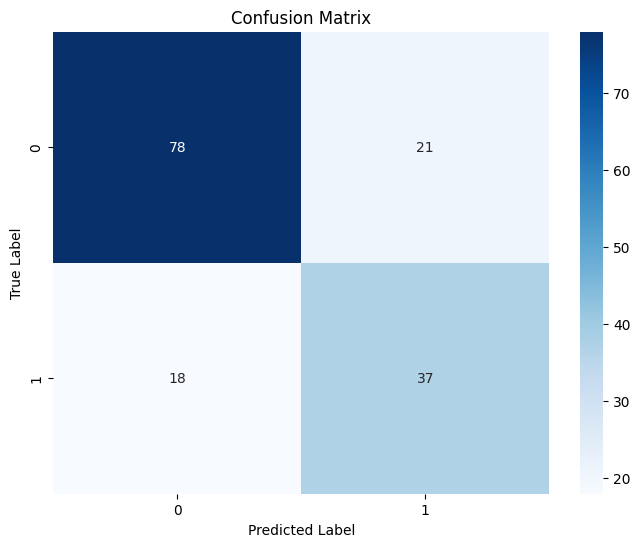

In [35]:
# confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# main diagonal:
    # true negatives: 78
    # true positves: 37

# False positives (Type I error): 21
# False negatives (Type II error): 18
# from these numbers the classification report can be calculated


In [36]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                 precision    recall  f1-score   support

tested_negative       0.81      0.79      0.80        99
tested_positive       0.64      0.67      0.65        55

       accuracy                           0.75       154
      macro avg       0.73      0.73      0.73       154
   weighted avg       0.75      0.75      0.75       154



### Interpretation of metrics:

**Sensitivity** (**recall** for positive class): TP/TP+FN : 37/(37+18) = 67.3% - the model correctly identifies 67.3% of all diabetic patients

**Specificity**: TN/TN+FP : 78/(78+21) = 78.8% - the model correctly identifies 78.8% of non-diabetic individuals

Positive Predictive Value (**Precision**): TP/TP+FP 37/(37+21) = 63.8% - when the model predicts diabetes, it's right 63.8% of the time

Negative Predictive Value: TN/FN+TN :  78/(78+18) = 81.3% - when the model predicts no diabetes, it's right 81.3% of the time